# P3 submission: Loading and Preprocessing part

In [1]:
# import all the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import regex as re
import os
import warnings
import spacy
import plotly.express as px
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from IPython.display import Image

from textblob import TextBlob
from IPython.display import display, HTML, Markdown

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import string
import nltk
from nltk.corpus import stopwords, words
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.sentiment import SentimentIntensityAnalyzer

from wordcloud import WordCloud
from collections import Counter

# statistics
from scipy.stats import ttest_rel, ttest_ind
import statsmodels.formula.api as smf

warnings.filterwarnings('ignore') # remove the warnings

# Load ratings.txt

We are processing data extracted from two similar beer rating websites: BeerAdvocate and RateBeer. The primary data structure is outlined in "ratings.txt," which includes user reviews providing information on beer (names, IDs, style, alcohol by volume), breweries, and users (date of review, user details, ratings, and comments on various aspects). Other supporting files include "beers.csv" (aggregated ratings for each beer), "Breweries" (information on breweries and their locations), and "Users" (user details on the number of ratings, reviews, and country of origin).

The most crucial file is "ratings.txt," as others are derived from its content. Due to its significant size (4.3 GB for BeerAdvocate and 3.95 GB for RateBeer), loading directly with a standard pipeline is impractical due to laptop memory limitations. To address this, we split the .txt files into N subfiles and load the data iteratively using a function.

The function allows control over the fraction of initial data loaded via the parameter **Nb_files**, which determines the number of subfiles to load. It also accommodates inherent differences between the two websites, such as additional review columns for BeerAdvocate.

Once loaded into DataFrames, we utilize the sample_data function to randomly sample a fraction of the data, enabling efficient handling of the substantial dataset.

In [2]:
def load_txt_file(website, Nb_files):
    if website == 'BeerAdvocate':
        # Specify the directory containing the text files 
        # Need to be outside of the repo folder and might need to change the path according to one's unique folders configuration
        directory = './../dataset_BeerReviews/BeerAdvocate/'
    else:
        directory = './../dataset_BeerReviews/RateBeer/'
        
    # Initialize an empty list to store DataFrames
    dfs = []

    # Loop through the files in reverse order (ratings-5.txt to ratings-1.txt)
    for i in range(Nb_files, 0, -1):
        file_name = f'ratings-{i}.txt'
        file_path = os.path.join(directory, file_name)

        with open(file_path, 'r') as f:
            text = f.read()

        # Remove double quotes at the beginning of each line
        data = re.sub('"', '', text)
        data = re.sub(r'^"', '', data, flags=re.MULTILINE)

        # Split the text into individual beer reviews
        beer_reviews = data.split('beer_name')

        # Extract the beer information from each review
        beer_data = []
        for review in beer_reviews:
            beer_info = {}
            for line in [entry.split(':', 1) for entry in review.split('\n') if ':' in entry]:# and 'text' not in entry]:
                if line:  # Check if the list is not empty
                    key, value = line[0].strip(), line[1].strip()
                    beer_info[key] = value
            beer_data.append(beer_info)

        # Convert the beer data into a DataFrame
        df = pd.DataFrame(beer_data)

        # Append the DataFrame to the list
        dfs.append(df)

    # Concatenate all DataFrames into a single DataFrame
    final_df = pd.concat(dfs, ignore_index=True)

    # Rename the columns depending on the website
    if website == 'BeerAdvocate':
        final_df.columns = [
            'beer_name',
            'beer_id',
            'brewery_name',
            'brewery_id',
            'style',
            'abv',
            'date',
            'user_name',
            'user_id',
            'appearance',
            'aroma',
            'palate',
            'taste',
            'overall',
            'rating',
            'text',
            'review'] # additional column compared to RB
    else:
        final_df.columns = [
            'beer_name',
            'beer_id',
            'brewery_name',
            'brewery_id',
            'style',
            'abv',
            'date',
            'user_name',
            'user_id',
            'appearance',
            'aroma',
            'palate',
            'taste',
            'overall',
            'rating',
            'text']
    return final_df

def sample_data(df, ratio):
    # sample the data to make it even smaller
    return df.sample(frac = ratio, random_state=42)

In [3]:
# Load data : for faster processing, we will only load 1 file out of the whole dataset
ratings_BA = load_txt_file('BeerAdvocate', 1)
ratings_RB = load_txt_file('RateBeer', 1)

In [4]:
# Sample data to make it even smaller AND RANDOMIZED (not randomized in the initial txt splitting process)
ratings_BA = sample_data(df = ratings_BA, ratio = 1)
ratings_RB = sample_data(df = ratings_RB, ratio = 1)

In [5]:
print(f"Length of ratings_BA (BeerAdvocate) dataframe : {len(ratings_BA)}")
print(f"Length of ratings_RB (RateBeer) dataframe : {len(ratings_RB)}")
display(ratings_BA.head(2),ratings_RB.head(2))

Length of ratings_BA (BeerAdvocate) dataframe : 444338
Length of ratings_RB (RateBeer) dataframe : 446793


,beer_name,beer_id,brewery_name,brewery_id,style,abv,date,user_name,user_id,appearance,aroma,palate,taste,overall,rating,text,review
43736,"Hello, My Name Is Ingrid",67199,BrewDog,16315,American Double / Imperial IPA,8.2,1370426400,aztraz,aztraz.671249,nan,nan,nan,nan,nan,3.50,nan,False
121830,Tetley's English Ale,706,Carlsberg-Tetley Brewing Ltd,8535,English Pale Ale,3.6,1451041200,hockeyfighter19,hockeyfighter19.683185,4.0,3.75,3.75,4.0,3.75,3.87,nan,False


,beer_name,beer_id,brewery_name,brewery_id,style,abv,date,user_name,user_id,appearance,aroma,palate,taste,overall,rating,text
123650,Dieu du Ciel Corne du Diable,31102,Dieu du Ciel,364,India Pale Ale (IPA),6.5,1382004000,pumpkinhead2,263831,4,5,3,6,12,3.00,"BiÃ¨re orangÃ©e cuivrÃ©e, voilÃ©e, moyennement..."
55875,Modelo Especial,744,Grupo Modelo (Corona),119,Pale Lager,4.5,1334052000,gunnfryd,31397,2,2,2,2,4,1.20,Bottle. Golden colour with a small white head....


### Load the other data

In [6]:
# BeerAdvocate
beers_BA = pd.read_csv("./../dataset_BeerReviews/BeerAdvocate/beers.csv")
breweries_BA = pd.read_csv("./../dataset_BeerReviews/BeerAdvocate/breweries.csv")
users_BA = pd.read_csv("./../dataset_BeerReviews/BeerAdvocate/users.csv")

# RateBeer
beers_RB = pd.read_csv("./../dataset_BeerReviews/RateBeer/beers.csv")
breweries_RB = pd.read_csv("./../dataset_BeerReviews/RateBeer/breweries.csv")
users_RB = pd.read_csv("./../dataset_BeerReviews/RateBeer/users.csv")

# matched_beer_data
beers_matched = pd.read_csv("./../dataset_BeerReviews/matched_beer_data/beers.csv", header=1)
breweries_matched = pd.read_csv("./../dataset_BeerReviews/matched_beer_data/breweries.csv", header = 1)
ratings_matched = pd.read_csv("./../dataset_BeerReviews/matched_beer_data/ratings.csv", header=1)
users_approx = pd.read_csv("./../dataset_BeerReviews/matched_beer_data/users_approx.csv", header=1)
users_matched = pd.read_csv("./../dataset_BeerReviews/matched_beer_data/users.csv", header=1)

**Check the type**

In [7]:
# Get types of features in each DataFrame
df_types = pd.concat([df.dtypes.rename(f"DataFrame {i+1}") for i, df in enumerate([ratings_BA, ratings_RB])], axis=1)
df_types

,DataFrame 1,DataFrame 2
beer_name,object,object
beer_id,object,object
brewery_name,object,object
brewery_id,object,object
style,object,object
abv,object,object
date,object,object
user_name,object,object
user_id,object,object
appearance,object,object


**Change the type**

One can see that all the features of **ratings_BA** and **ratings_RB** have a `object` type, which is not very convenient if we want to automate the visualization process, for example plotting the distribution of the numerical features in histograms. As a first preprocessing step, we will thus convert the type of the numerical variables to `float64` with the function **convert_type** below.

In [8]:
def convert_type(df, col):
    df[col] = df[col].astype('float64')
    return df

# columns including the numerical features for both websites
# user_id is numerical in RB but categorical in BA so we don't include it
numerical_cols = ['beer_id', 'brewery_id', 'abv', 'appearance', 'aroma', 'palate', 'taste', 'overall', 'rating']

for col in numerical_cols : 
    ratings_BA = convert_type(ratings_BA, col)
    ratings_RB = convert_type(ratings_RB, col)

In [9]:
# Get types of features in each DataFrame
df_types = pd.concat([df.dtypes.rename(f"DataFrame {i+1}") for i, df in enumerate([ratings_BA, ratings_RB])], axis=1)
df_types

,DataFrame 1,DataFrame 2
beer_name,object,object
beer_id,float64,float64
brewery_name,object,object
brewery_id,float64,float64
style,object,object
abv,float64,float64
date,object,object
user_name,object,object
user_id,object,object
appearance,float64,float64


## Combine all the dataframes

- matched (already standardized, need to check scales though of numerical features)
- BA (not standardized yet)
- RB (not standardized yet)

First we need to standardize the data from ratings_BA and ratings_RB before combining them with matched (which has already been standardized per year and per website, see paper)

Explain that we duplicate the matched samples (1 from BA and 1 from RB), so that we keep all the reviews, independently of the website.

### Preprocessing : standardize ratings_BA and ratings_RB annually

- Need to add time dimension first: month and year

In [10]:
def add_time_features(df):
    """
    Adds a 'month' and a 'year' features to the DataFrame based on the 'date' column.
    
    Parameters
    ----------
    df : DataFrame
        Contains data including a 'date' column.

    Returns
    -------
    df_m : DataFrame
        Contains the original data with an additional 'month' and 'year' features.
    """
    # Create a copy of the DataFrame
    df_time = df.copy()
    # Conversion of date feature from timestamp to text date
    pd.to_numeric(df_time['date'], errors='coerce', downcast='integer')
    # Convert 'date' to datetime and extract the date
    df_time.date = df.date.apply(lambda d: pd.to_datetime(d, unit='s'))
    df_time['date'] = df_time['date'].dt.date

    # Extract the month from the 'date' column and add it as a new feature 'month'
    df_time['month'] = pd.to_datetime(df_time['date']).dt.month
    # Extract the year from the 'date' column and add it as a new feature 'year'
    df_time['year'] = pd.to_datetime(df_time['date']).dt.year

    return df_time

def standardize_annually_ratings(df):
    """
    Standardizes the ratings annually and per website.
    
    Parameters
    ----------
    df : DataFrame
        Containing all data

    Returns
    -------
    df : DataFrame
        Containing all data with standardized ratings with additional column 'standardized_rating'.
                
    """
    df_copy = df.copy()
    grouped = df_copy.groupby('year')['rating'].agg(['mean', 'std'])
    df_copy = pd.merge(df_copy, grouped, left_on='year', right_index=True)
    df_copy['std_rating'] = (df_copy['rating'] - df_copy['mean']) / df_copy['std']
    
    return df_copy, grouped

In [11]:
# add time feature to standardize ratings by year and by website
ratings_BA_with_time = add_time_features(ratings_BA)
ratings_RB_with_time = add_time_features(ratings_RB)

# apply standardization
ratings_BA_standardized, mean_std_BA = standardize_annually_ratings(ratings_BA_with_time)
ratings_RB_standardized, mean_std_RB = standardize_annually_ratings(ratings_RB_with_time)

In [39]:
html_plots = "docs/assets/plot/"
png_plots = "imgs/"

In [40]:
def plots (fig, name):
    fig.write_html(html_plots + name + ".html")
    fig.write_image(png_plots + name + ".png")

    return Image(png_plots + name + ".png")

In [41]:
def plot_mean_std_errorbar(grouped_BA, grouped_RB, scale_factor, name):
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=grouped_BA.index, y=grouped_BA['mean'], name='BeerAdvocate',
                             error_y=dict(type='data', array=grouped_BA['std']*scale_factor, visible=True),
                             mode='lines+markers'))
    fig.add_trace(go.Scatter(x=grouped_RB.index, y=grouped_RB['mean'], name='RateBeer',
                             error_y=dict(type='data', array=grouped_RB['std']*scale_factor, visible=True),
                             mode='lines+markers'))
    fig.update_layout(title='Mean Ratings across Years', showlegend=True)
    
    return plots(fig, name)


### Some plots

Before standardization


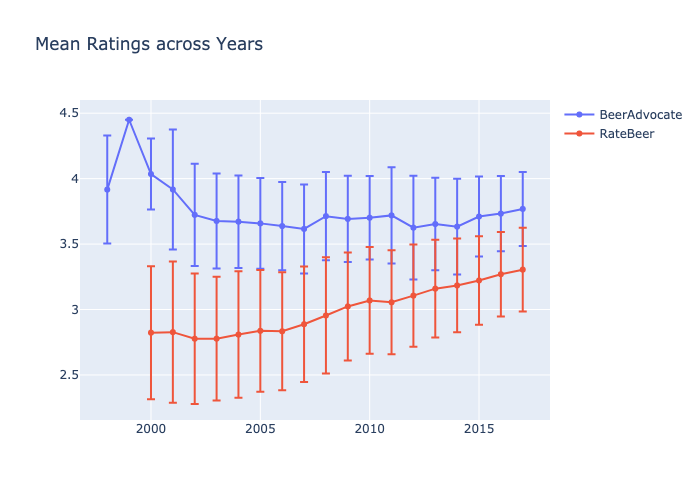

In [42]:
print("Before standardization")
plot_mean_std_errorbar(mean_std_BA, mean_std_RB, 0.5, "means")

After standardization


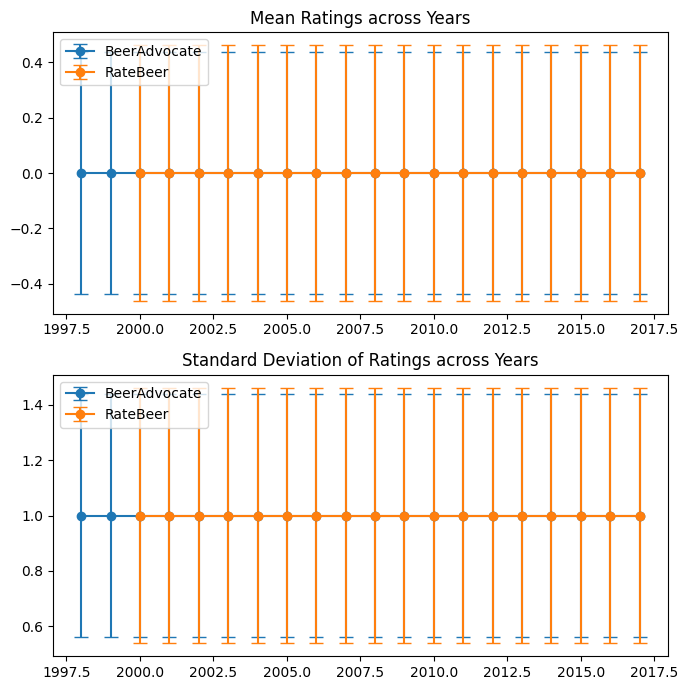

In [17]:
mean_std_BA_standardized = ratings_BA_standardized.groupby('year')['std_rating'].agg(['mean', 'std'])
mean_std_RB_standardized = ratings_RB_standardized.groupby('year')['std_rating'].agg(['mean', 'std'])
print("After standardization")
plot_mean_std_errorbar(mean_std_BA_standardized, mean_std_RB_standardized)

We still need to standardize the ratings from matched

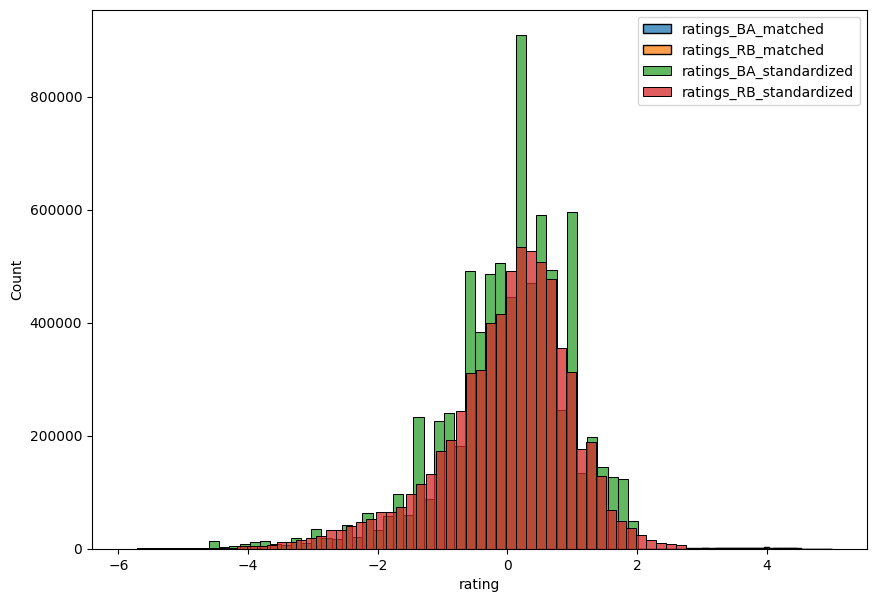

In [18]:
plt.figure(figsize=(10, 7))
sns.histplot(data=ratings_matched['rating'], bins=50, label = 'ratings_BA_matched')
sns.histplot(data=ratings_matched['rating.1'], bins=50, label = 'ratings_RB_matched')
sns.histplot(data=ratings_BA_standardized['std_rating'], bins=50, label = 'ratings_BA_standardized')
sns.histplot(data=ratings_RB_standardized['std_rating'], bins=50, label = 'ratings_RB_standardized')
plt.legend()
plt.show()

Standardize ratings from the matched

In [19]:
ratings_matched_copy = ratings_matched.copy(deep=True)
ratings_matched_copy['beer_id.1'] = ratings_matched_copy['beer_id']
ratings_matched_copy['brewery_id.1'] = ratings_matched_copy['brewery_id']
ratings_matched_copy['beer_name.1'] = ratings_matched_copy['beer_name']
ratings_matched_copy['brewery_name.1'] = ratings_matched_copy['brewery_name']

# Retrieve the columns of interest for BeerAdvocate
ratings_matched_BA = ratings_matched_copy.iloc[:, :17]
ratings_matched_BA = ratings_matched_BA.drop(['review'], axis=1) # drop the column that is not common to both websites

#Retrieve the columns of interest for RateBeer
ratings_matched_RB = ratings_matched_copy.iloc[:, 17:]
ratings_matched_RB['overall.1'] = ratings_matched_RB['overall.1']*5/20
ratings_matched_RB['aroma.1'] = ratings_matched_RB['aroma.1']*5/10
ratings_matched_RB['taste.1'] = ratings_matched_RB['taste.1']*5/10
ratings_matched_RB.columns = ratings_matched_BA.columns

# add time features to standardize by year
ratings_matched_BA_with_time = add_time_features(ratings_matched_BA)
ratings_matched_RB_with_time = add_time_features(ratings_matched_RB)

# standardize ratings of matched data to have mean 0 and std 1
ratings_matched_BA_standardized, mean_std_BA_matched = standardize_annually_ratings(ratings_matched_BA_with_time) # adds column 'std_rating'
ratings_matched_RB_standardized, mean_std_RB_matched = standardize_annually_ratings(ratings_matched_RB_with_time) # adds column 'std_rating'

### Check

- all dataframes have an additional column 'std_rating' with the standardized rating.

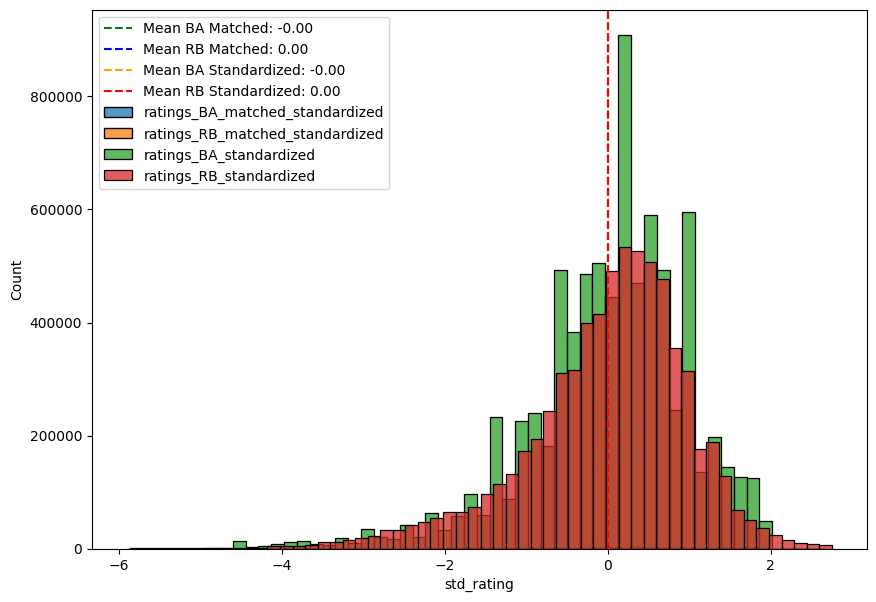

In [20]:
# Compute mean values for each distribution
mean_rating_BA_matched = ratings_matched_BA_standardized['std_rating'].mean()
mean_rating_RB_matched = ratings_matched_RB_standardized['std_rating'].mean()
mean_rating_BA_standardized = ratings_BA_standardized['std_rating'].mean()
mean_rating_RB_standardized = ratings_RB_standardized['std_rating'].mean()


plt.figure(figsize=(10, 7))
sns.histplot(data=ratings_matched_BA_standardized['std_rating'], bins=50, label = 'ratings_BA_matched_standardized')
sns.histplot(data=ratings_matched_RB_standardized['std_rating'], bins=50, label = 'ratings_RB_matched_standardized')
sns.histplot(data=ratings_BA_standardized['std_rating'], bins=50, label = 'ratings_BA_standardized')
sns.histplot(data=ratings_RB_standardized['std_rating'], bins=50, label = 'ratings_RB_standardized')

# Plot vertical lines for mean values
plt.axvline(x=mean_rating_BA_matched, color='green', linestyle='--', label=f'Mean BA Matched: {mean_rating_BA_matched:.2f}')
plt.axvline(x=mean_rating_RB_matched, color='blue', linestyle='--', label=f'Mean RB Matched: {mean_rating_RB_matched:.2f}')
plt.axvline(x=mean_rating_BA_standardized, color='orange', linestyle='--', label=f'Mean BA Standardized: {mean_rating_BA_standardized:.2f}')
plt.axvline(x=mean_rating_RB_standardized, color='red', linestyle='--', label=f'Mean RB Standardized: {mean_rating_RB_standardized:.2f}')

plt.legend()
plt.show()

### Concatenate everything

Length of ratings matched: 21964
Length of ratings BA: 7907480
Length of ratings RB: 6830716
Length of combined dataset: 14782088


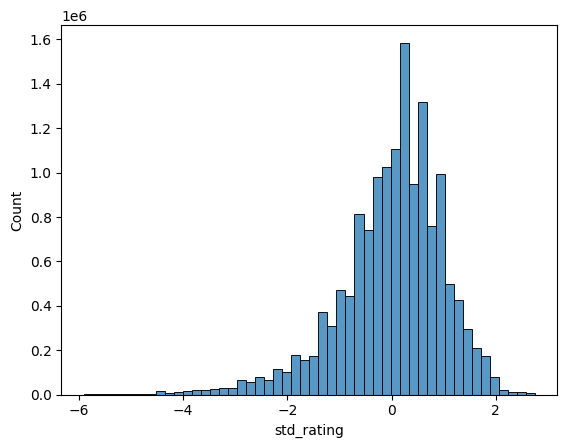

,beer_name,beer_id,brewery_name,brewery_id,style,abv,date,user_name,user_id,appearance,...,taste,overall,rating,text,review,month,year,mean,std,std_rating
6473263,Double Jack,50697.0,Firestone Walker Brewing Co.,2210.0,American Double / Imperial IPA,9.5,2013-07-18,jroberts8811,jroberts8811.713926,NaN,...,NaN,NaN,4.75,nan,False,7.0,2013.0,3.855454,0.634897,1.408964
6442779,Palmero,83801.0,Hangar 24 Brewery,16843.0,Dubbel,7.0,2013-06-03,dertyd,dertyd.441101,NaN,...,NaN,NaN,3.50,nan,False,6.0,2013.0,3.855454,0.634897,-0.559860


In [21]:
# concatenate matched data from both websites
ratings_matched_BA_RB = pd.concat([ratings_matched_BA_standardized, ratings_matched_RB_standardized], axis=0)
ratings_matched_BA_RB.sort_values(by=['beer_id', 'user_id'], inplace=True)

# concatenate matched data with ratings_BA and ratings_RB
all_data= pd.concat([ratings_BA_standardized, 
                    ratings_RB_standardized,
                    ratings_matched_BA_RB], axis=0)

# test
print(f"Length of ratings matched: {len(ratings_matched)}")
print(f"Length of ratings BA: {len(ratings_BA)}")
print(f"Length of ratings RB: {len(ratings_RB)}")
print(f"Length of combined dataset: {len(all_data)}")

# check
sns.histplot(data=all_data['std_rating'], bins=50)
plt.show()

all_data.head(2)

**Copy paste this code until here to load and combine the dataset correctly**

NB: rating to use: **std_rating**

### **Loading and preprocessing done**

---


In [22]:
# downsampling the data for faster processing
all_data = all_data.sample(frac = 0.3, random_state=42)
print(f"Length of combined dataset after downsampling: {len(all_data)}")

Length of combined dataset after downsampling: 4434626


##### In this section we will construct two ranking of the best breweries by grading the breweries based on the grades obtained by their beers. We filter out the breweries with too few reviews to maintain the ranking credibility and ensure that the rating reflects a consensus among significant number of reviewers. In both ranking we start by computing the averages obtained by each of the brewery's beers. Here is the first ranking system.

##### The first ranking is a weighted ranking, when computing the grade of the brewerie we leverage the importance of each beers by the number of reviews it has received. This ranking isn't really sensitive to beers with a low number of reviews we thus don't filter out beers with little number of reviews.  

##### However, this classification may not be considered representative of a brewery's quality. A brewery could have a very popular beer that is highly rated and drunk a lot, and the rest of its beers that are less highly rated and drunk less. This brewery in the first ranking will obtain a good average. However, the quality of the brewery can be questioned since only one of its beers is well rated. 

##### The second ranking takes this effect into account. It calculates a brewery's rating by averaging the beers without taking their frequency into account. This ranking could represent a better ranking of a brewery quality because it values quality among different beers. This ranking is very sensitive to beers that are rated very few times, which is why we have to filter out beers with too few reviews. We have decided that a beer with fewer than 3 reviews cannot be considered. 




### Distribution of the number of reviews per beer and breweries 

In [23]:
def plot_reviews(beers, breweries):
    fig, axs = plt.subplots(2, 1)

    axs[0].hist(beers,bins=100, log=True,histtype='step')
    axs[0].set_title("Distribution of the number of review per beer")
    
    
    axs[1].hist(breweries,bins=100 , log=True,histtype='step')
    axs[1].set_title("Distribution of the number of review per breweries")
    plt.subplots_adjust(bottom=0.15)
    plt.tight_layout()
    plt.show()

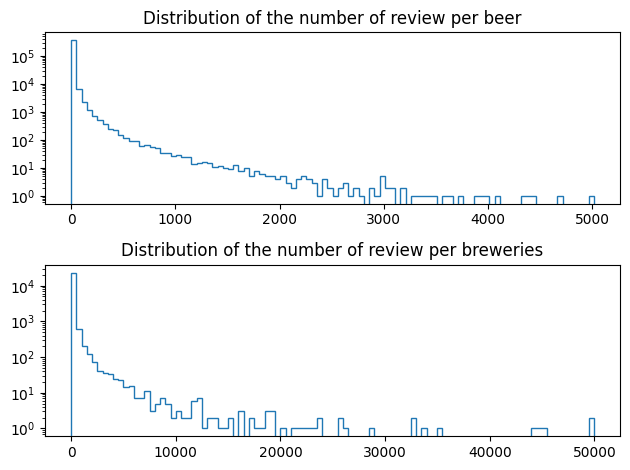

In [24]:
nb_rev_beer = all_data.groupby('beer_name').apply(lambda x:len(x))
nb_rev_breweries = all_data.groupby('brewery_name').apply(lambda x:len(x))
plot_reviews(nb_rev_beer, nb_rev_breweries)

In [25]:
ratings_filtered = all_data.groupby('beer_name').filter(lambda x: len(x)>10)
values =sum(1 for element in nb_rev_beer.values if element <= 10)
length_beer =len(nb_rev_beer.values)
length_review =all_data.shape[0]
print(f"We kicked {values} beeer out of {length_beer} and {all_data.shape[0]-ratings_filtered.shape[0]} out of {all_data.shape[0]} reviews ")
print(f"which is {np.round(values/length_beer*100,3)}% of the beer and {np.round(100*(all_data.shape[0]-ratings_filtered.shape[0])/all_data.shape[0], 3)}% of the reviews")

We kicked 322460 beeer out of 380667 and 850111 out of 4434626 reviews 
which is 84.709% of the beer and 19.17% of the reviews


In [26]:
#Justfier avec graph le threshold brasserie
all_data = all_data.groupby('brewery_name').filter(lambda x: len(x)>30)
kicked_brew =sum(1 for element in nb_rev_breweries.values if element <= 10)
length_brew =len(nb_rev_breweries.values)
print(f"We kicked {kicked_brew} breweries out of {length_brew}")# and {ratings_BA.shape[0]-length_review} out of {ratings_BA.shape[0]} reviews ")
print(f"which is {np.round(kicked_brew/length_brew*100,3)}% of the breweries")

We kicked 11777 breweries out of 24667
which is 47.744% of the breweries


**Functions to plot**

In [27]:
def plot_ranking(ranking_sorted, topN):
    plt.figure(figsize=(8, topN/4))
    colors = plt.cm.Reds(ranking_sorted[:topN] / ranking_sorted[:topN].max())
    plt.barh(ranking_sorted.index[:topN], ranking_sorted[:topN], color=colors)
    plt.gca().invert_yaxis()
    plt.title(f'Top {topN} Breweries')
    plt.show()
    
def compare_ranking(ranking_sorted_1, ranking_sorted_2, topN):
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    colors_1 = plt.cm.Reds(ranking_sorted_1[:topN] / ranking_sorted_1[:topN].max())
    axes[0].barh(ranking_sorted_1.index[:topN], ranking_sorted_1[:topN], color=colors_1)
    axes[0].invert_yaxis()
    axes[0].set_title(f'Top {topN} Breweries - Weighted Ranking')
    
    colors_2 = plt.cm.Blues(ranking_sorted_2[:topN] / ranking_sorted_2[:topN].max())
    axes[1].barh(ranking_sorted_2.index[:topN], ranking_sorted_2[:topN], color=colors_2)
    axes[1].invert_yaxis()
    axes[1].set_title(f'Top {topN} Breweries - Fair Ranking')
    
    plt.tight_layout()
    plt.show()

Group into brewery, beer and year

In [28]:
grouped_brew = all_data.groupby(['brewery_name',"beer_name"])["std_rating"]
grouped_brew_year = all_data.groupby(['brewery_name',"beer_name","year"])["std_rating"]

# 1- Weighted Ranking

### All-time ranking

In [29]:
grouped_agg = grouped_brew.agg(['mean', 'size'])
grouped_agg['weighted_rating'] = grouped_agg['mean'] * grouped_agg['size']

#Here we calculate the scores by taking into account the nb of ratings 
weighted_ranking = grouped_agg.groupby('brewery_name')['weighted_rating'].sum() / grouped_agg.groupby('brewery_name')['size'].sum()
weighted_ranking_sorted = weighted_ranking.sort_values(ascending=False)

print(weighted_ranking_sorted.head())

brewery_name
Brasserie Rochefort           1.237480
The Alchemist                 1.151464
Brouwerij 3 Fonteinen         1.054277
Tree House Brewing Company    1.040501
Russian River Brewing         1.029255
dtype: float64


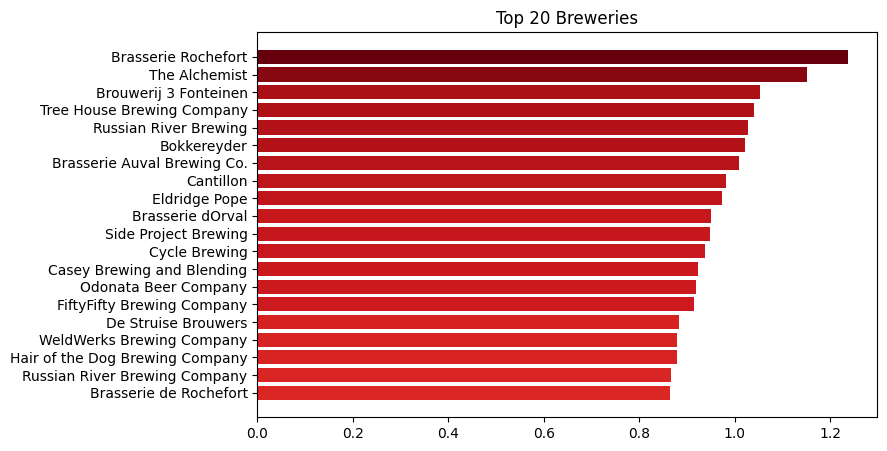

In [30]:
plot_ranking(weighted_ranking_sorted, 20)

### Ranking per year 

In [31]:
grouped_agg_year = grouped_brew_year.agg(['mean', 'size'])
grouped_agg_year['weighted_rating'] = grouped_agg_year['mean'] * grouped_agg_year['size']

weighted_ranking_year = grouped_agg_year.groupby(['brewery_name',"year"])['weighted_rating'].sum() / grouped_agg_year.groupby(['brewery_name',"year"])['size'].sum()

averaged_per_year = weighted_ranking_year.reset_index(level='brewery_name')
averaged_per_year.columns.values[1] = 'std_rating'

top_brewery_year_avg = averaged_per_year.groupby('year').apply(lambda x: x.nlargest(10, 'std_rating'))

top_across_avg = top_brewery_year_avg.groupby("brewery_name").value_counts().nlargest(5)

top_brewery_year_avg.head(10)

brewery_name  std_rating
year   year                                                                 
1996.0 1996.0                     Berkshire Brewing Company Inc.    0.000000
1998.0 1998.0                                           Unibroue    1.728215
       1998.0  Hair of the Dog Brewing Company / Brewery and ...    0.991087
       1998.0                                     Orkney Brewery    0.991087
       1998.0                                   Brewery Ommegang    0.952291
       1998.0                                Ipswich Ale Brewery    0.835902
       1998.0                 Boston Beer Company (Samuel Adams)    0.738912
       1998.0  Privatbrauerei Franz Inselkammer KG / Brauerei...    0.603125
       1998.0                           Sprecher Brewing Company    0.564329
       1998.0                          Sierra Nevada Brewing Co.    0.370348

In [32]:
weighted_ranking_year_sorted = top_brewery_year_avg.groupby("year").first()
weighted_ranking_year_sorted.head(10)

,brewery_name,std_rating
year,,
1996.0,Berkshire Brewing Company Inc.,0.000000
1998.0,Unibroue,1.728215
1999.0,Long Trail Brewing Co.,1.243195
2000.0,Brauerei Heller,1.423471
2001.0,Friese Bierbrouwerij,1.734103
2002.0,Rosengarten,2.002766
2003.0,Barley Johns Brew Pub,1.960074
2004.0,Mohan Meakin Breweries,1.986884
2005.0,Brauerei Fritz Gutmann,2.350632


# 2- Second ranking: overall consumer satisfaction

Ranking name: **fair_ranking**

In [33]:
ratings_filtered = all_data.groupby('beer_name').filter(lambda x: len(x)>1)
grouped_brew = ratings_filtered.groupby(['brewery_name',"beer_name"])["std_rating"]
grouped_brew_year = ratings_filtered.groupby(['brewery_name',"beer_name","year"])["std_rating"]

In [34]:
grouped_agg = grouped_brew.agg(['mean'])

fair_ranking = grouped_agg.groupby('brewery_name')['mean'].mean()
fair_ranking_sorted = weighted_ranking.sort_values(ascending=False)

print(fair_ranking_sorted.head())

brewery_name
Brasserie Rochefort           1.237480
The Alchemist                 1.151464
Brouwerij 3 Fonteinen         1.054277
Tree House Brewing Company    1.040501
Russian River Brewing         1.029255
dtype: float64


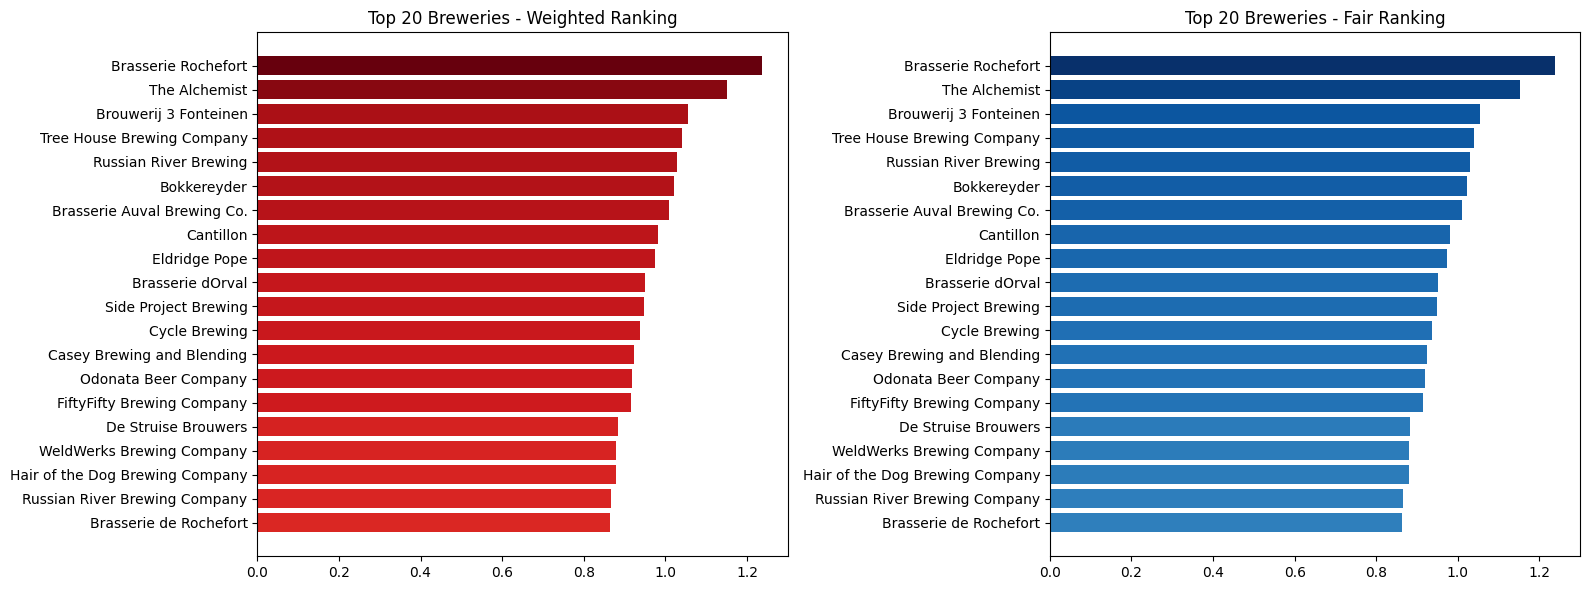

In [35]:
compare_ranking(weighted_ranking_sorted, fair_ranking_sorted, 20)

Rank per year 

In [36]:
grouped_agg_year = grouped_brew_year.agg(['mean'])

fair_ranking = grouped_agg_year.groupby(['brewery_name',"year"])['mean'].mean()

averaged_fair_per_year = fair_ranking.reset_index(level='brewery_name')
averaged_fair_per_year.columns.values[1] = 'std_rating'

top_brewery_year_fair = averaged_fair_per_year.groupby('year').apply(lambda x: x.nlargest(10, 'std_rating'))
top_across_fair = top_brewery_year_fair.groupby("brewery_name").value_counts().nlargest(5)

top_brewery_year_fair.head(10)

brewery_name  std_rating
year   year                                                                 
1996.0 1996.0                     Berkshire Brewing Company Inc.         NaN
1998.0 1998.0                                           Unibroue    1.728215
       1998.0  Hair of the Dog Brewing Company / Brewery and ...    0.991087
       1998.0                                     Orkney Brewery    0.991087
       1998.0                                   Brewery Ommegang    0.952291
       1998.0                                Ipswich Ale Brewery    0.835902
       1998.0                 Boston Beer Company (Samuel Adams)    0.738912
       1998.0  Privatbrauerei Franz Inselkammer KG / Brauerei...    0.603125
       1998.0                           Sprecher Brewing Company    0.564329
       1998.0                 John Harvard's Brewery & Ale House    0.370348

In [37]:
fair_ranking_year_sorted = top_brewery_year_fair.groupby("year").first()
fair_ranking_year_sorted.head(10)

,brewery_name,std_rating
year,,
1996.0,Berkshire Brewing Company Inc.,NaN
1998.0,Unibroue,1.728215
1999.0,Long Trail Brewing Co.,1.243195
2000.0,Brauerei Heller,1.423471
2001.0,Friese Bierbrouwerij,1.734103
2002.0,Rosengarten,2.002766
2003.0,Barley Johns Brew Pub,1.960074
2004.0,Mohan Meakin Breweries,1.986884
2005.0,Brauerei Fritz Gutmann,2.350632


# Don't look further 

In [38]:
best_brew_weighted, best_brew_fair

NameError: name 'best_brew_weighted' is not defined

In [ ]:
stats_per_year = grouped_year.agg(['mean', 'size'])

In [ ]:
stats_per_year['weighted_rating'] = stats_per_year['mean'] * stats_per_year['size']

#Herre we calculate the scores on one side we take into account the nb of ratings and not on the other one
df_average_year = stats_per_year.groupby(['brewery_name',"year"])['weighted_rating'].sum() / stats_per_year.groupby(['brewery_name',"year"])['size'].sum()
df_fair_year = stats_per_year.groupby(['brewery_name',"year"])['mean'].mean()

top_beers_year_avg = averaged_per_year.groupby('year').apply(lambda x: x.nlargest(10, 'std_rating'))

print(top_beers_year_avg)

top_across_avg = top_beers_year_avg.groupby("brewery_name").value_counts().nlargest(3)

print(top_across_avg)

#Plot and take the n best
#sns.histplot(df_average)
#sns.histplot(df_fair)

# best_brew_average = df_average_year.nlargest(10)
# best_brew_fair = df_fair_year.nlargest(10)

#print(best_brew_average ,best_brew_fair )

brewery_name                     year  
33 Acres                         2013.0   -0.033031
                                 2014.0    0.234331
                                 2015.0    0.180674
                                 2016.0    0.083284
                                 2017.0   -0.241633
33 Acres Brewing Co.             2013.0    0.193041
                                 2014.0    0.250495
                                 2015.0    0.441590
                                 2016.0    0.228460
                                 2017.0   -0.009526
4 Mile Brewing Co.               2014.0    0.152539
                                 2015.0    0.391106
                                 2016.0   -0.090527
                                 2017.0   -0.037245
4 Mile Brewing Co. &#40;BC&#41;  2014.0   -0.462444
                                 2015.0   -0.173298
                                 2016.0   -0.350096
                                 2017.0   -0.096521
5 Paddles Brewing Co.   

In [ ]:

fair_per_year = df_fair_year.reset_index("brewery_name")

fair_per_year.columns.values[1] = "std_rating"

# Optionally, you can rename the columns for clarity
#averaged_per_year.columns = ['year', 'average_rating']

# Display the resulting DataFrame
print(averaged_per_year.index,averaged_per_year.columns,type(averaged_per_year))

Index([2013.0, 2014.0, 2015.0, 2016.0, 2017.0, 2013.0, 2014.0, 2015.0, 2016.0,
       2017.0,
       ...
       2015.0, 2016.0, 2017.0, 2010.0, 2011.0, 2012.0, 2013.0, 2014.0, 2015.0,
       2016.0],
      dtype='float64', name='year', length=11207) Index(['brewery_name', 'std_rating'], dtype='object') <class 'pandas.core.frame.DataFrame'>


In [ ]:
#On garde les dix meilleurs par an

top_beers_year_avg = averaged_per_year.groupby('year').apply(lambda x: x.nlargest(10, 'std_rating'))
top_beers_year_fair = fair_per_year.groupby('year').apply(lambda x: x.nlargest(10, 'std_rating'))

#On compte le nombre de fois ou chaque brasserie est rentrée dans le top 10 et on prend les 3 meilleurs 


top_beers_year_avg , top_beers_year_fair

(                                    brewery_name  std_rating
 year   year                                                 
 1998.0 1998.0                           Unibroue    1.040728
        1998.0                      Whitbread PLC    0.683140
        1998.0      Belhaven Brewery Company Ltd.    0.525559
        1998.0                     Orkney Brewery    0.489194
        1998.0                Elgood and Sons Ltd    0.380100
 ...                                          ...         ...
 2017.0 2017.0             Hill Farmstead Brewery    1.627798
        2017.0  Microbrasserie de l'ile d'Orléans    1.557343
        2017.0            Lawson's Finest Liquids    1.521116
        2017.0          Left Hand Brewing Company    1.462530
        2017.0         Thomas Caffrey Brewing Co.    1.362957
 
 [189 rows x 2 columns],
                                     brewery_name  std_rating
 year   year                                                 
 1998.0 1998.0                           Un

In [ ]:
top_beers_year_avg = averaged_per_year.groupby('year').apply(lambda x: x.nlargest(10, 'std_rating'))
top_across_avg = top_beers_year_avg.groupby("brewery_name").value_counts().nlargest(3)
top_across_fair = top_beers_year_fair.groupby("brewery_name").value_counts().nlargest(3)
print(top_across_avg , top_across_fair)

brewery_name                  std_rating
8 Wired Brewing Co.           1.518843      1
AJB - Anglo Japanese Brewery  1.205836      1
AleSmith Brewing Company      1.750665      1
Name: count, dtype: int64 brewery_name                  std_rating
8 Wired Brewing Co.           1.518843      1
AJB - Anglo Japanese Brewery  1.205836      1
AleSmith Brewing Company      1.161153      1
Name: count, dtype: int64


In [ ]:
top_beers_year_avg.sample(30)

,,brewery_name,rating
year,year,,
2005,2005,Brasserie Dieu du Ciel!,4.240000
2002,2002,Brutopia,4.600000
2008,2008,Whitewater Brewing Co,4.300000
2014,2014,Cotleigh Brewery,4.187500
2017,2017,O'Hanlon Brewing Co. Ltd.,4.330769
2013,2013,Driftwood Brewery,4.114313
2014,2014,Driftwood Brewery,4.177939
2012,2012,Crannóg Ales,4.166667
2015,2015,Atlas Brewery Ltd,4.290000
